1. The first two problems are based on the same data. The data in data(foxes)
are 116 foxes from 30 different urban groups in England. These fox groups
are like street gangs. Group size (groupsize) varies from 2 to 8 individuals.
Each group maintains its own (almost exclusive) urban territory. Some ter-
ritories are larger than others. The area variable encodes this information.
Some territories also have more avgfood than others. And food influences
the weight of each fox. Assume this DAG:

* A -> F
* F -> G
* F -> W
* G -> W


where F is avgfood, G is groupsize, A is area, and W is weight.
Use the backdoor criterion and estimate the total causal influence of A on
F. What effect would increasing the area of a territory have on the amount
of food inside it?


In [1]:
import pandas as pd
from pathlib import Path
import statsmodels.formula.api as smf
import pymc3 as pm


# Read in the data
foxes = pd.read_csv(Path('week03') /'foxes.csv', sep=";")

In [2]:
foxes


,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85
...,...,...,...,...,...
111,29,0.67,4,2.75,4.81
112,29,0.67,4,2.75,3.94
113,30,0.41,3,1.91,3.16
114,30,0.41,3,1.91,2.78


In [3]:
smf.ols(formula="avgfood ~ area", data=foxes).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                avgfood   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     403.9
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           2.87e-39
Time:                        09:54:23   Log-Likelihood:                 111.37
No. Observations:                 116   AIC:                            -218.7
Df Residuals:                     114   BIC:                            -213.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1539      0.031      4.965      0.000       0.092       0.215
area           0.1886      0.009     20.097      0.000       0.170       0.207
==============================================================================
Omnibus:                        9.314   Durbin-Watson:                   0.688
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                3.808
Skew:                           0.121   Prob(JB):                        0.149
Kurtosis:                       2.146   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    area = pm.Normal('area', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    mu = intercept + area * foxes['area']
    avgfood = pm.Normal('avgfood', mu=mu, sd=sigma, observed=foxes['avgfood'])
    trace = pm.sample(1000, tune=1000, cores=8)


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 40 seconds.
The acceptance probability does not match the target. It is 0.8795895697849112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8814127413151209, but should be close to 0.8. Try to increase the number of tuning steps.


/var/folders/ff/3y2196b13bq0nbm3_ms25nyh0000gp/T/ipykernel_15058/798611224.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, figsize=(12, 12))


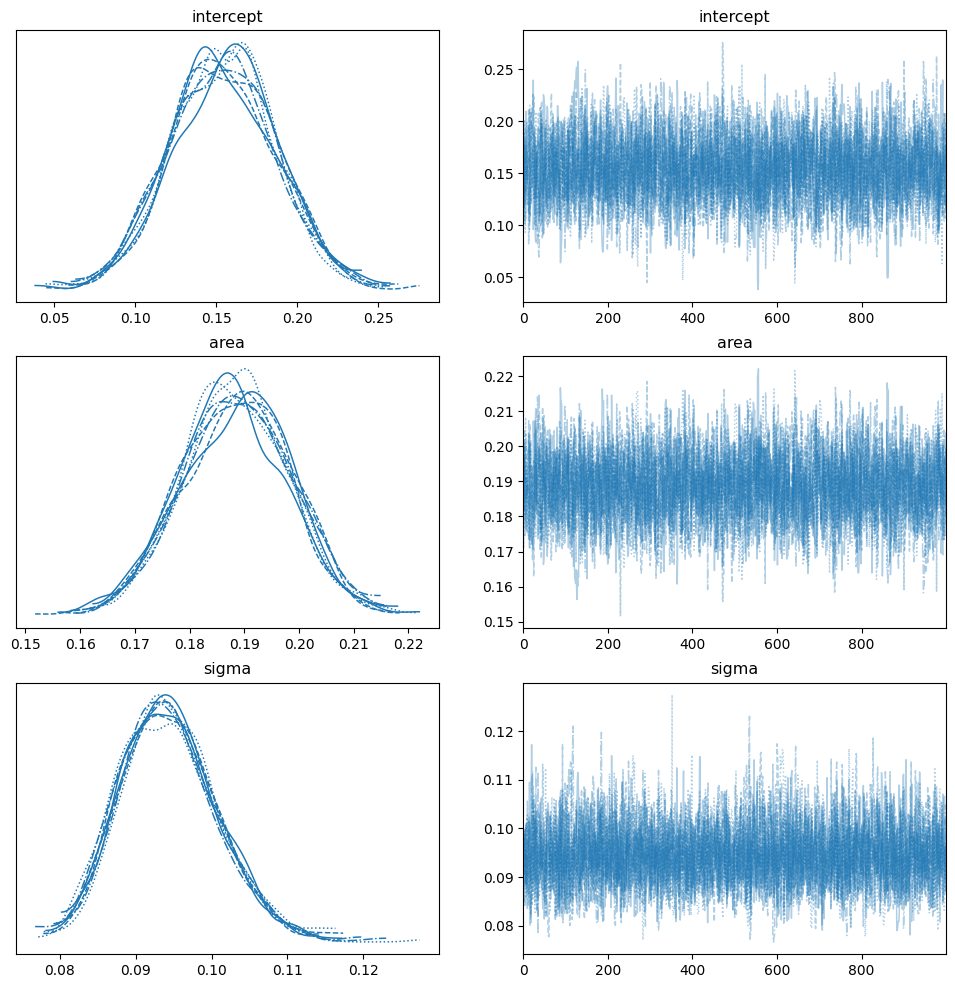

In [5]:
with model:
    pm.traceplot(trace, figsize=(12, 12))

2. Infer the total causal effect of adding food F to a territory on the weight
W of foxes. Can you calculate the causal effect by simulating an intervention
on food?


In [6]:
smf.ols(formula="weight ~ avgfood", data=foxes).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.07152
Date:                Mon, 13 Feb 2023   Prob (F-statistic):              0.790
Time:                        09:55:21   Log-Likelihood:                -183.65
No. Observations:                 116   AIC:                             371.3
Df Residuals:                     114   BIC:                             376.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6420      0.434     10.684      0.000       3.781       5.503
avgfood       -0.1495      0.559     -0.267      0.790      -1.257       0.958
==============================================================================
Omnibus:                        1.841   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.604
Skew:                           0.155   Prob(JB):                        0.448
Kurtosis:                       2.514   Cond. No.                         8.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    avgfood = pm.Normal('avgfood', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    mu = intercept + avgfood * foxes['avgfood']
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=foxes['weight'])
    trace = pm.sample(1000, tune=1000, cores=8)



Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6704980326180626, but should be close to 0.8. Try to increase the number of tuning steps.


/var/folders/ff/3y2196b13bq0nbm3_ms25nyh0000gp/T/ipykernel_15058/798611224.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, figsize=(12, 12))


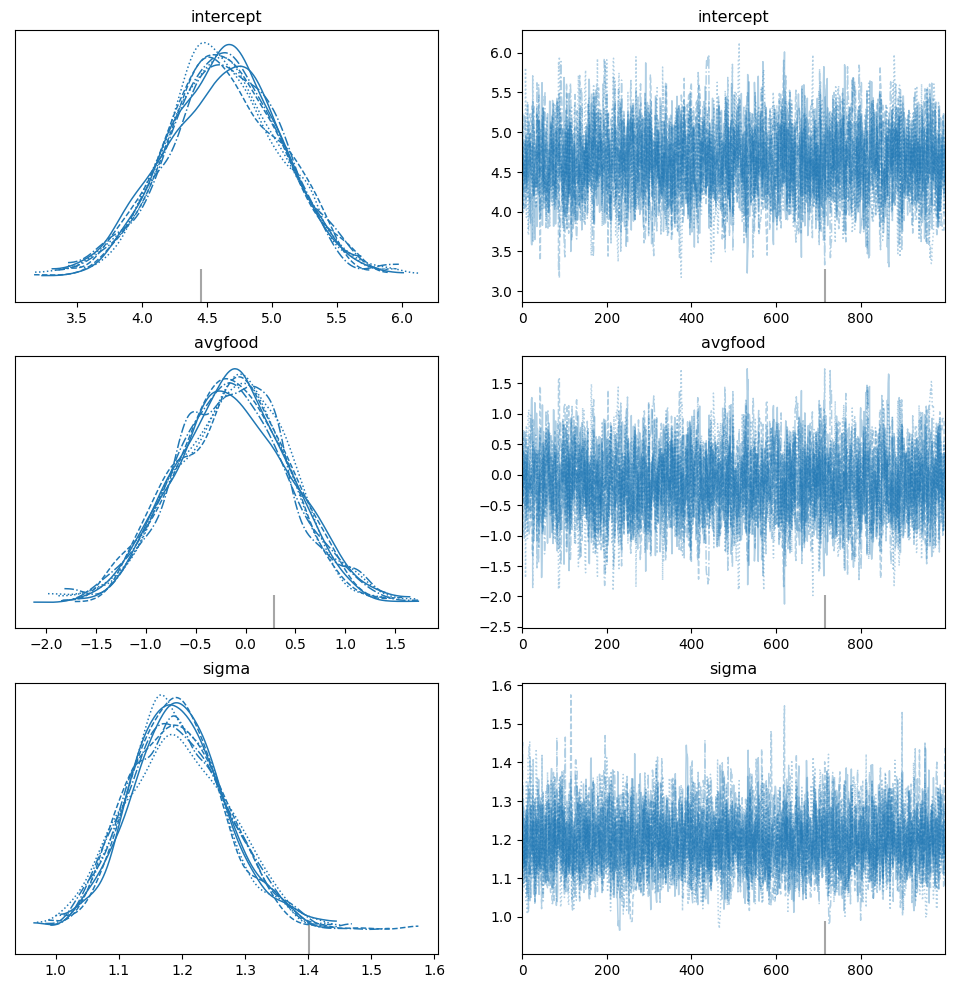

In [8]:
with model:
    pm.traceplot(trace, figsize=(12, 12))

In [9]:
# G -> F
# F -> W
# G -> W
# total effect? control for G
# direct effect? control for G

3. Infer the direct causal effect of adding food F to a territory on the weight
W of foxes. In light of your estimates from this problem and the previous
one, what do you think is going on with these foxes?
(Optional fourth problem on next page.)


In [10]:
smf.ols(formula="weight ~ avgfood + groupsize", data=foxes).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     6.481
Date:                Mon, 13 Feb 2023   Prob (F-statistic):            0.00216
Time:                        09:56:08   Log-Likelihood:                -177.39
No. Observations:                 116   AIC:                             360.8
Df Residuals:                     113   BIC:                             369.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1232      0.438      9.414      0.000       3.255       4.991
avgfood        3.8275      1.229      3.114      0.002       1.393       6.263
groupsize     -0.5687      0.158     -3.589      0.000      -0.883      -0.255
==============================================================================
Omnibus:                        0.522   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.229
Skew:                           0.085   Prob(JB):                        0.892
Kurtosis:                       3.136   Cond. No.                         57.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sd=10)
    avgfood = pm.Normal('avgfood', mu=0, sd=10)
    groupsize = pm.Normal('groupsize', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=1)
    mu = intercept + avgfood * foxes['avgfood'] + groupsize * foxes['groupsize']
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=foxes['weight'])
    trace = pm.sample(1000, tune=1000, cores=8)

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/var/folders/ff/3y2196b13bq0nbm3_ms25nyh0000gp/T/ipykernel_15058/798611224.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, figsize=(12, 12))


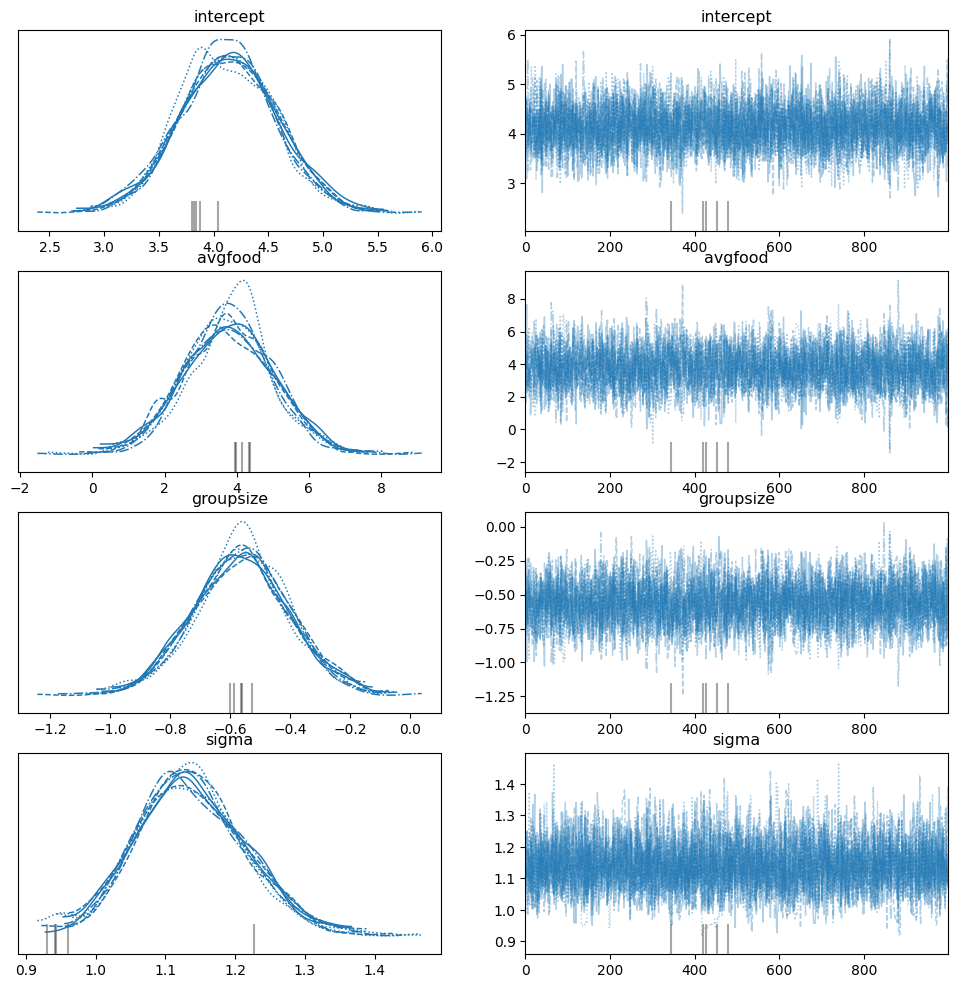

In [12]:
with model:
    pm.traceplot(trace, figsize=(12, 12))

4. We should control on **G** to estimate direct effect, it closes the path

In [13]:
import numpy as np

N = 1000
u = np.random.normal(0, 1, N)
f = u + np.random.normal(0, 1, N)
g = u + f + np.random.normal(0, 1, N)
w = 2.5 * f + 0.25 * g + np.random.normal(0, 1, N)

df = pd.DataFrame({'f': f, 'g': g, 'w': w})

# Total effect of f on w: condition on u
smf.ols(formula="w ~ f + u", data=df).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      w   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     7027.
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        09:57:04   Log-Likelihood:                -1466.6
No. Observations:                1000   AIC:                             2939.
Df Residuals:                     997   BIC:                             2954.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0347      0.033     -1.045      0.296      -0.100       0.030
f              2.7621      0.033     82.565      0.000       2.696       2.828
u              0.2205      0.047      4.657      0.000       0.128       0.313
==============================================================================
Omnibus:                        2.181   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                2.054
Skew:                           0.081   Prob(JB):                        0.358
Kurtosis:                       3.152   Cond. No.                         2.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Direct effect of f on w: condition on g
smf.ols(formula="w ~ f + g", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      w   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     7474.
Date:                Mon, 13 Feb 2023   Prob (F-statistic):               0.00
Time:                        09:57:33   Log-Likelihood:                -1437.7
No. Observations:                1000   AIC:                             2881.
Df Residuals:                     997   BIC:                             2896.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0347      0.032     -1.076      0.282      -0.098       0.029
f              2.5081      0.046     54.164      0.000       2.417       2.599
g              0.2469      0.027      9.065      0.000       0.193       0.300
==============================================================================
Omnibus:                        1.273   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.529   Jarque-Bera (JB):                1.140
Skew:                           0.067   Prob(JB):                        0.566
Kurtosis:                       3.098   Cond. No.                         4.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""